# **Logistic Regression with a Neural Network mindset**

Welcome to your first (required) programming assignment! You will build a logistic regression classifier to recognize Politics-Society News. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## **1 - Packages**

First, let's run the cell below to import all the packages that you will need during this assignment. 

In [3]:
# libraries for dataset preparation, feature engineering
try:
    import numpy as np
except ImportError:
    !pip install numpy
    import numpy as np
try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt
try:
    import pandas as pd
except ImportError:
    !pip install pandas
    import pandas as pd
try:
    from sklearn import model_selection, preprocessing
except ImportError:
    !pip install scikit-learn
    from sklearn import model_selection, preprocessing
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
except ImportError:
    !pip install scikit-learn
    from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(123) #for reprodicible results
%matplotlib inline

## **2 - Dataset preparation**

**Problem Statement**:

You are given a dataset ("news_dataset.csv") containing a set of Vietnamses news labeled as politics-society (y="Chinhtrixahoi") or others (y="Khac")
* Actually, "Khac" comprises of "Phap luat", "Kinh doanh", "Doi song", "The gioi" news

You will build a simple news-classification algorithm that can correctly classify news as politics-society or others.

Let's get more familiar with the dataset. Load the data by running the following code.

In [6]:
import os 
if not os.path.exists('datasets/news_dataset.csv'):
    # download from gg drive: https://drive.google.com/file/d/1KFkG_qYY0BpX45-yJjciOUme2bk6WHq6/view?usp=drive_link
    !gdown --id 1KFkG_qYY0BpX45-yJjciOUme2bk6WHq6 --output datasets/news_dataset.csv
df = pd.read_csv('datasets/news_dataset.csv')

In [4]:
# The dataframe has two columns, text and label 
df.head()

,text,label
0,Nhân tài… đến rồi đi Trong cuộc khảo sát nhan...,Chinhtrixahoi
1,Tử hình Lâm Bích Thủy và Toàn '6 Ngón' \n Hôm...,Khac
2,"Dùng ống chích tống tiền 1 tỉ đồng Tối 19-12,...",Khac
3,Mekong Capital tăng đầu tư vào VN \n Ông Chris...,Khac
4,Tàu hoả húc xe tải gây ách tắc hơn 9 giờ \n Đo...,Chinhtrixahoi


In [5]:
size_politics_society = df[df['label'] == 'Chinhtrixahoi'].shape[0]
size_others = df[df['label'] == 'Khac'].shape[0]
print('Number of politics-society documents: %s' %size_politics_society)
print('Number of other documents: %s' %size_others)

Number of politics-society documents: 200
Number of other documents: 200


In [6]:
# an example of a politics-society news
df['text'][4]

"Tàu hoả húc xe tải gây ách tắc hơn 9 giờ \n Đoàn tàu D2 từ Sài Gòn ra Đà Nẵng đã húc phải một xe tải Kamaz tại Km 1264 trên đường sắt thuộc huyện Vạn Ninh, tỉnh Khánh Hòa. Xe tải hư hại nặng, đầu máy xe lửa trật đường ray. Tai nạn xảy ra vào 22h30' ngày 1/7 khiến nhiều đoàn tàu bị đình trệ. \n Đến 7h30 ngày 2/7, giao thông trên đường sắt xuyên Việt mới trở lại bình thường. \n Theo ông Nguyễn Đình Tân, Giám đốc Xí nghiệp vận tải đường sắt Phú Khánh, nguyên nhân tai nạn do xe tải chở vật liệu nặng băng qua đường sắt nhưng không vượt qua được và nằm chắn ngang trên đường ray. Tài xế xe tải đã bỏ trốn. \n Tại ga Đà Nẵng, lúc 10h ngày 2/7 nhà ga mới thông báo về sự kiện này khiến hơn 500 hành khách đi trên 7 chuyến tàu E, S đã mua vé từ Đà Nẵng đi ra phía bắc rất bực mình vì phải đợi tàu nhiều giờ, nhất là hàng trăm thí sinh cùng người nhà đi thi đại học tại Vinh và Hà Nội. \n  \n "

Next, we will split the dataset into training and test sets so that we can train and test classifier. Also, we will encode our target column so that it can be used in our model.

In [7]:
# split the dataset into training and test datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['text'], df['label'])

# label encode the target variable, encode labels to 0 or 1
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)
print('["Chinhtrixahoi" "Khac"] labels corresponds to %s labels' %encoder.transform(["Chinhtrixahoi", "Khac"]))

["Chinhtrixahoi" "Khac"] labels corresponds to [0 1] labels


The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset.

### **TF-IDF Vectors as features**
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

In [8]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

In [9]:
# Getting transformed training and testing dataset
print('Number of training documents: %s' %str(xtrain_tfidf.shape[0]))
print('Number of testing documents: %s' %str(xtest_tfidf.shape[0]))
print('Number of features of each document: %s' %str(xtrain_tfidf.shape[1]))
print('xtrain_tfidf shape: %s' %str(xtrain_tfidf.shape))
print('train_y shape: %s' %str(train_y.shape))
print('xtest_tfidf shape: %s' %str(xtest_tfidf.shape))
print('test_y shape: %s' %str(test_y.shape))

Number of training documents: 300
Number of testing documents: 100
Number of features of each document: 5000
xtrain_tfidf shape: (300, 5000)
train_y shape: (300,)
xtest_tfidf shape: (100, 5000)
test_y shape: (100,)


Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

**Exercise:**: For convenience, you should now transpose the training and testing numpy-array, and expand the shape of the lable arrays in the axis=0 position.

After this, our training (and test) dataset is a numpy-array where each column represents a document vector. There should be the number of training documents (respectively the number of testing documents) as the number of columns.

In [10]:
### START CODE HERE ###
train_y = np.expand_dims(train_y, axis=0)
test_y = np.expand_dims(test_y, axis=0)

# for convenience in this exercise, we also use toarray() to convert sparse to dense matrix 
xtrain_tfidf =  xtrain_tfidf.T.toarray() 
xtest_tfidf =  xtest_tfidf.T.toarray()
### END CODE HERE ###

In [11]:
# New shape 
print('xtrain_tfidf shape: %s' %str(xtrain_tfidf.shape))
print('train_y shape: %s' %str(train_y.shape))
print('xtest_tfidf shape: %s' %str(xtest_tfidf.shape))
print('test_y shape: %s' %str(test_y.shape))

xtrain_tfidf shape: (5000, 300)
train_y shape: (1, 300)
xtest_tfidf shape: (5000, 100)
test_y shape: (1, 100)


## **3 - General Architecture of the learning algorithm**

It's time to design a simple algorithm to distinguish politics-society news from other news.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

**The below image is an analogy of the network architecture of an image classifier to a text classifier.**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## **4 - Building the parts of our algorithm**

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### **4.1 - Helper functions**

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions. Use np.exp().

In [12]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [13]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### **4.2 - Initializing parameters**

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [14]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0.
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [15]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

### **4.3 - Forward and Backward propagation**

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [18]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = float(X.shape[1])
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X) + b)                                    # compute activation
    cost = -(1/m) * (np.sum((Y*np.log(A))+ ((1-Y)*np.log(1-A))))     # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m)*(np.dot(X,(A-Y).T))
    db = (1/m)*(np.sum(A-Y))
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [19]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### **4.4 - Optimization**
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [20]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w,b,X,Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [21]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591] [ 0.12259159]] </td>
    </tr>
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042] [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>
</table>

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [24]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m), dtype=int)
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a news being present
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if (A[0][i] > 0.5):
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction, A

In [25]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)[0]))

predictions = [[1 1 0]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>What to remember:

You've implemented several functions that:

- Initialize (w,b)

- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent

- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [26]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)[0]
    Y_prediction_train = predict(w,b,X_train)[0]

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [27]:
d = model(xtrain_tfidf, train_y, xtest_tfidf, test_y, num_iterations = 3000, learning_rate = .5, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.600526
Cost after iteration 200: 0.532763
Cost after iteration 300: 0.480424
Cost after iteration 400: 0.438448
Cost after iteration 500: 0.403815
Cost after iteration 600: 0.374616
Cost after iteration 700: 0.349577
Cost after iteration 800: 0.327811
Cost after iteration 900: 0.308676
Cost after iteration 1000: 0.291697
Cost after iteration 1100: 0.276510
Cost after iteration 1200: 0.262833
Cost after iteration 1300: 0.250441
Cost after iteration 1400: 0.239156
Cost after iteration 1500: 0.228831
Cost after iteration 1600: 0.219344
Cost after iteration 1700: 0.210595
Cost after iteration 1800: 0.202500
Cost after iteration 1900: 0.194986
Cost after iteration 2000: 0.187993
Cost after iteration 2100: 0.181466
Cost after iteration 2200: 0.175362
Cost after iteration 2300: 0.169640
Cost after iteration 2400: 0.164264
Cost after iteration 2500: 0.159205
Cost after iteration 2600: 0.154435
Cost after iteration 2700: 0.149931
Cost

**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is around 84%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. You'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

In [28]:
# Example of a news that was wrongly classified.
index = 1
print(list(test_x[index:index+1])[0])
true = test_y[0][index]

 Đề nghị không chống phá giá đối với giày da xuất khẩu của VN Thủ tướng Chính phủ VN gửi thư tới Thủ tướng Bỉ và Chủ tịch EC đề nghị Liên minh châu Âu (EU) xem xét thỏa đáng vụ kiện chống phá giá đối với giày mũ da xuất khẩu của VN. 
 (NLĐ)- Ngày 19-1, tin từ Bộ Ngoại giao cho biết, trong chuyến công du một số nước châu Âu, đặc phái viên Thủ tướng Chính phủ, Thứ trưởng Bộ Ngoại giao Lê Văn Bàng, đã trao thư của Thủ tướng Chính phủ VN gửi Thủ tướng Bỉ và Chủ tịch EC đề nghị Liên minh châu Âu (EU) xem xét thỏa đáng vụ kiện chống phá giá đối với giày mũ da xuất khẩu của VN. Đặc phái viên Lê Văn Bàng nhấn mạnh ngành giày có tầm quan trọng đặc biệt về kinh tế và xã hội đối với VN và cho rằng cuộc điều tra đang tác động tiêu cực đối với ngành giày và phát triển kinh tế – xã hội cũng như công cuộc xóa đói giảm nghèo ở VN. Ông Lê Văn Bàng cũng nhấn mạnh thực tế là xuất khẩu giày của VN vào EU đang giảm và các công ty VN không có khả năng bán phá giá, không đe dọa ngành công nghiệp châu Âu. VN 

In [30]:
# Example of a news that was wrongly classified.
index = 1
print(list(test_x[index:index+1])[0])
true = test_y[0][index]
pred = d['Y_prediction_test'][0][index]
print('------------------------------------------------------------')
print('This is "%s" news, you predicted it is "%s" news' %(encoder.inverse_transform([true]), encoder.inverse_transform([pred])))

 Đề nghị không chống phá giá đối với giày da xuất khẩu của VN Thủ tướng Chính phủ VN gửi thư tới Thủ tướng Bỉ và Chủ tịch EC đề nghị Liên minh châu Âu (EU) xem xét thỏa đáng vụ kiện chống phá giá đối với giày mũ da xuất khẩu của VN. 
 (NLĐ)- Ngày 19-1, tin từ Bộ Ngoại giao cho biết, trong chuyến công du một số nước châu Âu, đặc phái viên Thủ tướng Chính phủ, Thứ trưởng Bộ Ngoại giao Lê Văn Bàng, đã trao thư của Thủ tướng Chính phủ VN gửi Thủ tướng Bỉ và Chủ tịch EC đề nghị Liên minh châu Âu (EU) xem xét thỏa đáng vụ kiện chống phá giá đối với giày mũ da xuất khẩu của VN. Đặc phái viên Lê Văn Bàng nhấn mạnh ngành giày có tầm quan trọng đặc biệt về kinh tế và xã hội đối với VN và cho rằng cuộc điều tra đang tác động tiêu cực đối với ngành giày và phát triển kinh tế – xã hội cũng như công cuộc xóa đói giảm nghèo ở VN. Ông Lê Văn Bàng cũng nhấn mạnh thực tế là xuất khẩu giày của VN vào EU đang giảm và các công ty VN không có khả năng bán phá giá, không đe dọa ngành công nghiệp châu Âu. VN 

Let's also plot the cost function and the gradients.

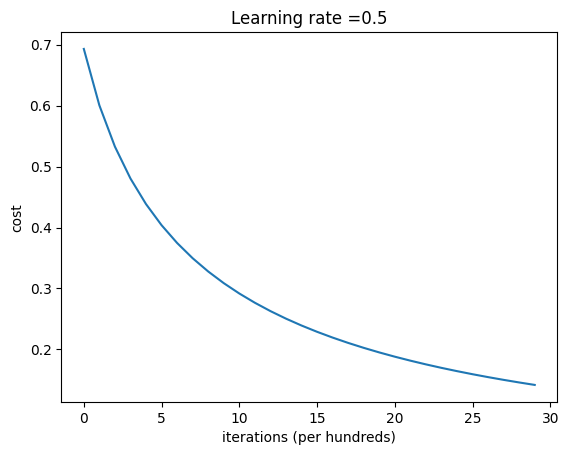

In [31]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## **6 - Further analysis (optional/ungraded exercise)**

Congratulations on building your first text classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01
train accuracy: 86.66666666666667 %
test accuracy: 69.0 %

-------------------------------------------------------

learning rate is: 0.1
train accuracy: 97.33333333333333 %
test accuracy: 84.0 %

-------------------------------------------------------

learning rate is: 0.5
train accuracy: 99.66666666666667 %
test accuracy: 84.0 %

-------------------------------------------------------



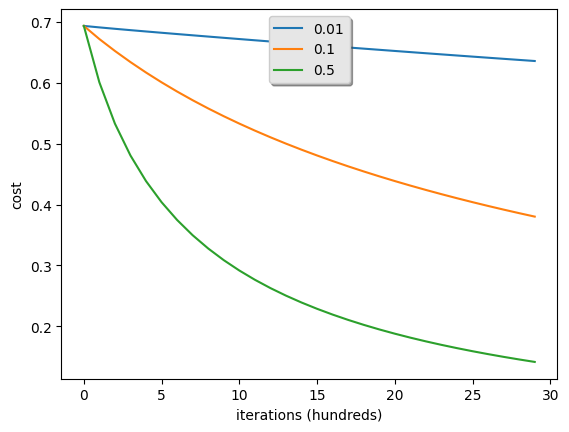

In [32]:
learning_rates = [0.01, 0.1, 0.5]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(xtrain_tfidf, train_y, xtest_tfidf, test_y, num_iterations = 3000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large, the cost may oscillate up and down. It may even diverge (though in this example, using 0.5 does not have that problem and still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


## **7 - Test with your own news (optional/ungraded exercise)**

Congratulations on finishing this assignment. You can use your own text and see the output of your model.

["Chinhtrixahoi" "Khac"] labels corresponds to [0 1] labels

In [33]:
text = """Làm mẹ khi quá trẻ dễ bị loãng xương
Những cô gái mới lớn mang thai sẽ gia tăng nguy cơ xương bị yếu đi. Trong một nghiên cứu mới tại Mỹ, 1/3 số bà mẹ ở tuổi thiếu niên có chỉ số điển hình của bệnh loãng xương, hoặc có dấu hiệu báo trước căn bệnh này.
"Cần phải đảm bảo rằng những bà mẹ thiếu niên tiêu thụ đủ lượng canxi trong thời gian mang thai - 1.300 milligram mỗi ngày, để đáp ứng nhu cầu canxi của cả mẹ lẫn bào thai", Kimberly O. O'Brien tại Trường sức khoẻ cộng đồng Johns Hopkins Bloomberg ở Baltimore, phát biểu.
Canxi đặc biệt cần thiết trong thời kỳ mang thai do bào thai khi lớn lên cần nhiều chất dinh dưỡng để hình thành xương, trong lúc bản thân các thiếu nữ cũng cần nhiều canxi cho chính mình. Thực tế, 40% lượng xương của con gái được hình thành trong độ tuổi dậy thì.
Mặc dù có hơn nửa triệu thiếu nữ sinh con tại Mỹ mỗi năm, chưa có nhiều thông tin về việc mang thai ảnh hưởng thế nào tới xương của người mẹ. O'Brien và cộng sự đã nghiên cứu 23 cô gái mang thai trong độ tuổi 13,5 đến 18,3. Cũng giống như người lớn, lượng tiêu thụ canxi trong thời kỳ mang thai của các cô gái trẻ cao hơn là sau khi sinh.
Khoảng 1/3 các bà mẹ trẻ có dấu hiệu xương mỏng đi đáng kể sau khi sinh. Trong số 15 em được đo xương trong 3-4 tháng sau khi sinh, 2 em có đủ dấu hiệu của bệnh loãng xương. 3 em khác có dấu hiệu của tiền loãng xương.
Tuy vậy, không phải cứ mang thai ở độ tuổi thiếu niên là có xương bị yếu đi. Kết quả nghiên cứu chỉ ra rằng tiêu thụ nhiều lượng canxi hơn trong thời kỳ mang thai sẽ giúp chống lại tình trạng yếu xương.
"""

x_tfidf =  tfidf_vect.transform([text]).T.toarray()

In [34]:
predict(d["w"], d["b"], x_tfidf)

(array([[1]]), array([[0.63010904]]))

<font color='blue'>
**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings 
    - Try others parameters of TfidfVectorizer, such as ngrams, lowercase
    - See what features are in a Tf-idf vector
    - Test with different feature representation other than Tf-idf

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c